# 전북대학교 통계학과 데이터경진대회 (2022) 

### 팀명: 맑은하늘팀 
### 주제 : 클러스터링과 회귀분석을 이용한 공기 정화시스템 입지선정

### Import 

In [1]:
# !pip install googlemaps

import pandas as pd
import scipy.stats as stats
import numpy as np
import os,re 
import folium
import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (13, 8)
plt.rcParams['font.family'] = 'AppleGothic' #한글 깨짐 방지를 위해 폰트설정

import warnings
warnings.filterwarnings("ignore")



### Read Data 

Data 출처 : 서울 열린 데이터 광장 공공데이터 [(링크)](https://data.seoul.go.kr/dataList/datasetList.do)


`-` read data 

In [3]:
심도=pd.read_csv('data/stationDepth.csv', encoding='euc-kr')
심도.head()

,호선,정거장명,정거장층수,형식,ⓐ지반고(해발고도+100.3m),ⓑ레일면고(해발고도+100.3m),정거장 깊이[선로기준](ⓐ-ⓑ)(m),정거장 깊이[승강장기준](ⓐ-ⓑ-1.1)(m),비고
0,1,서울역,B2,섬 식,129.99,117.04,12.95,11.85,4호선환승
1,1,시 청,B2,상대식,129.97,118.82,11.15,10.05,2호선환승
2,1,종 각,B2,상대식,128.77,116.24,12.53,11.43,NaN
3,1,종로3가,B2,상대식,124.38,112.04,12.34,11.24,3호선 / 5호선환승
4,1,종로5가,B2,상대식,121.75,109.26,12.49,11.39,NaN


In [4]:
건축정보 = pd.read_csv('data/stationInfo.csv', encoding='euc-kr')
건축정보.loc[0, '역명'] = '서울역'
건축정보.head()

,연번,호선,역명,형식,길이(M),층수,면적(m²),준공연도
0,1,1,서울역,섬식,210,B2,10805.0,1974
1,2,1,시청,상대식,210,B2,11317.0,1974
2,3,1,종각,상대식,210,B2,10410.2,1974
3,4,1,종로3가,상대식,210,B2,9311.0,1974
4,5,1,종로5가,상대식,210,B2,10465.0,1974


In [6]:
환기구 = pd.read_csv('data/stationVent.csv', encoding = 'euc-kr')
환기구.head()

,호선,번호,구 간,용도,기능,위치,높이(m),구조물 형태,비고
0,1,3,서울역,역사,급기,기타,0.48,탑형,NaN
1,1,4,서울역,역사,배기,기타,0.50,탑형,NaN
2,1,5,서울역,역사,배기,녹지,0.24,지면형,NaN
3,1,6,서울역,역사,급기,녹지,0.55,탑형,NaN
4,1,7,서울역~시청,본선,자연,보도,0.64,탑형,NaN


In [7]:
공기질 = pd.read_csv('data/aircondition_2020.csv', encoding = 'euc-kr')
공기질.head()

,호선,역사명,미세먼지,초미세먼지,이산화탄소,포름알데히드,일산화탄소
0,1호선,서울역,40.6,29.3,515,12.2,2.3
1,1호선,시청,45.1,28.1,456,9.4,2.1
2,1호선,종각,44.2,25.1,511,9.0,2.7
3,1호선,종로3가,61.5,32.3,457,9.0,1.1
4,1호선,종로5가,106.2,62.0,541,12.5,2.2


In [8]:
승객 = pd.read_csv('data/passengers.csv', encoding = 'euc-kr')
승객.head()

,호선,역번호,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,1,150,서울역(1),3198290.0,2271168.0,1601396.0,1803550.0,2112629.0,2201148.0,2391615.0,1986290,1705059,2121997,2218093,1648262
1,1,151,시청(1),1477362.0,1149641.0,888317.0,874072.0,962697.0,1042088.0,1134098.0,922958,853911,994423,1072922,857434
2,1,152,종각,2462560.0,1945843.0,1475933.0,1586710.0,1745454.0,1892509.0,2069902.0,1626359,1378130,1702997,1758055,1314449
3,1,153,종로3가(1),1935106.0,1421415.0,1095035.0,1224282.0,1374997.0,1360814.0,1523797.0,1212158,1051916,1298918,1297683,953894
4,1,154,종로5가,1527217.0,1149021.0,947157.0,1040487.0,1182917.0,1182427.0,1263489.0,1017196,988661,1124400,1100466,930913


In [9]:
혼잡도 = pd.read_csv("data/congestion.csv", encoding = 'utf-8')
혼잡도.head()

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00,24:30:00
0,평일,1호선,150,서울역,상선,8.2,12.9,21.5,28.4,46.7,...,15.1,15.9,17.1,16.0,19.0,15.2,10.5,7.8,6.0,0.9
1,평일,1호선,150,서울역,하선,11.8,13.5,12.2,17.8,26.4,...,36.5,31.2,37.6,44.6,45.6,37.8,28.8,19.3,7.1,0.4
2,평일,1호선,151,시청,상선,7.7,11.2,19.6,24.4,36.2,...,18.7,18.3,20.7,22.0,24.0,18.7,13.7,10.0,6.9,1.0
3,평일,1호선,151,시청,하선,9.5,11.3,11.6,16.7,23.2,...,32.0,27.7,34.8,39.3,37.4,36.3,23.0,18.1,4.0,1.6
4,평일,1호선,152,종각,상선,6.3,8.1,15.5,16.6,22.7,...,25.8,24.2,30.0,31.9,34.0,26.8,18.8,12.5,9.1,1.2


### Preprocessing

`승객`

In [10]:
# 기본키를 역번호로 설정
승객['총승객수'] = 승객.loc[:, '1월':'12월'].sum(axis=1)
승객['역명'] = 승객.역명.str.split("\(").apply(lambda x : x[0])

승객 = 승객.loc[:, ['역번호', '호선', '역명' ,'총승객수']]

승객.head()

,역번호,호선,역명,총승객수
0,150,1,서울역,25259497.0
1,151,1,시청,12229923.0
2,152,1,종각,20958901.0
3,153,1,종로3가,15750015.0
4,154,1,종로5가,13454351.0


`심도`

In [11]:
심도.정거장명 = 심도.정거장명.str.replace(" ", "") #정거장명에 공백 제거
심도.비고 = 심도.비고.str.split('\/')
심도.비고[심도.비고.isna()] = 0
심도['환승역개수'] = [0 if 환승역 == 0 else len(환승역) for 환승역 in 심도.비고] #역당 환승역의 개수
심도 = 심도.iloc[:, [0,1,4,5,7,9]]
심도.columns = ['호선', '역명', '지반고', '레일면고',  '정거장깊이', '환승역개수']
심도['환기구'] = 0
심도.head()

,호선,역명,지반고,레일면고,정거장깊이,환승역개수,환기구
0,1,서울역,129.99,117.04,11.85,1,0
1,1,시청,129.97,118.82,10.05,1,0
2,1,종각,128.77,116.24,11.43,0,0
3,1,종로3가,124.38,112.04,11.24,2,0
4,1,종로5가,121.75,109.26,11.39,0,0


In [12]:
import re
환기구_split = 환기구.iloc[:, 2].apply(lambda x : re.split('~|∼|-', x)) # 환기구가 역 사이에 있는것들을 split

#환기구가 두 역에 걸쳐있으면 0.5개로 취급
for i in range(len(환기구)):
    호선 = 환기구.loc[i, '호선']
    역명 = 환기구_split[i]
    
    
    if len(역명) == 1:
        심도.loc[(심도.역명 == 역명[0]) & (심도.호선 == 호선), '환기구'] += 1
        
    else: #환기구가 두개의 역 사이에 존재할 때
        for 개별역명 in 역명:
            심도.loc[(심도.역명 == 개별역명) & (심도.호선 == 호선), '환기구'] += 0.5
    
심도



,호선,역명,지반고,레일면고,정거장깊이,환승역개수,환기구
0,1,서울역,129.99,117.04,11.85,1,8.0
1,1,시청,129.97,118.82,10.05,1,13.5
2,1,종각,128.77,116.24,11.43,0,11.5
3,1,종로3가,124.38,112.04,11.24,2,10.5
4,1,종로5가,121.75,109.26,11.39,0,12.0
...,...,...,...,...,...,...,...
273,8,남한산성입구,166.05,147.34,17.61,0,0.0
274,8,단대오거리,153.71,139.50,13.11,0,1.5
275,8,신흥,143.89,128.47,14.32,0,5.0
276,8,수진,137.63,122.76,13.77,0,5.0


`건축정보`

In [13]:
건축정보['연식'] = 2020 - 건축정보['준공연도'] 
건축정보 = 건축정보.loc[:, ['호선','역명','면적(m²)', '연식']]
건축정보.columns = ['호선','역명','면적','연식']
건축정보.head()

,호선,역명,면적,연식
0,1,서울역,10805.0,46
1,1,시청,11317.0,46
2,1,종각,10410.2,46
3,1,종로3가,9311.0,46
4,1,종로5가,10465.0,46


`공기질`

In [14]:
공기질['호선'] = 공기질['호선'].apply(lambda x : int(x[0]))
공기질.columns = ['호선', '역명'] + list(공기질.columns[2:])
공기질.head()

,호선,역명,미세먼지,초미세먼지,이산화탄소,포름알데히드,일산화탄소
0,1,서울역,40.6,29.3,515,12.2,2.3
1,1,시청,45.1,28.1,456,9.4,2.1
2,1,종각,44.2,25.1,511,9.0,2.7
3,1,종로3가,61.5,32.3,457,9.0,1.1
4,1,종로5가,106.2,62.0,541,12.5,2.2


`혼잡도`

In [15]:
혼잡도.loc[혼잡도['조사일자'] != '평일', '조사일자'] = '주말'
혼잡도 = 혼잡도.groupby("역번호").mean().reset_index() #혼잡도의 평균을 구함
혼잡도['평균혼잡도'] = 혼잡도.loc[:, "5:30":].mean(axis = 1)
혼잡도 = 혼잡도.loc[:, ['역번호','평균혼잡도']]
혼잡도.head()

,역번호,평균혼잡도
0,150,28.724786
1,151,27.414530
2,152,26.819231
3,153,27.073504
4,154,27.154274


In [17]:
좌표 = pd.read_csv("data/stationLocation.csv", encoding='utf-8')
좌표.columns = ['역명', '위도', '경도']
좌표.loc[좌표.역명 == '서울', '역명'] = '서울역'

`merge`

In [18]:
merge1 = pd.merge(승객, 심도, how = 'inner', on =['호선', '역명'])
merge2 = pd.merge(merge1, 건축정보, how = 'inner', on =['호선', '역명'])
merge3 = pd.merge(merge2, 혼잡도, how ='inner', on =['역번호'])
merge4 = pd.merge(merge3, 좌표, how = 'inner', on =['역명'])
subway = pd.merge(merge4, 공기질, how = 'inner', on =['호선', '역명'])

In [19]:
# 최종 병합된 데이터프레임
subway.head()

,역번호,호선,역명,총승객수,지반고,레일면고,정거장깊이,환승역개수,환기구,면적,연식,평균혼잡도,위도,경도,미세먼지,초미세먼지,이산화탄소,포름알데히드,일산화탄소
0,150,1,서울역,25259497.0,129.99,117.04,11.85,1,8.0,10805.0,46,28.724786,37.554648,126.972559,40.6,29.3,515,12.2,2.3
1,151,1,시청,12229923.0,129.97,118.82,10.05,1,13.5,11317.0,46,27.414530,37.564718,126.977108,45.1,28.1,456,9.4,2.1
2,201,2,시청,12917285.0,132.01,111.02,19.89,1,13.5,12561.0,36,35.682051,37.564718,126.977108,83.6,53.1,514,6.2,0.4
3,152,1,종각,20958901.0,128.77,116.24,11.43,0,11.5,10410.2,46,26.819231,37.570161,126.982923,44.2,25.1,511,9.0,2.7
4,153,1,종로3가,15750015.0,124.38,112.04,11.24,2,10.5,9311.0,46,27.073504,37.571607,126.991806,61.5,32.3,457,9.0,1.1


In [20]:
#공기질의 표준화점수를 얻음
subway['미세먼지'] /= 100
subway['초미세먼지'] /= 50
subway['이산화탄소'] /= 1000
subway['포름알데히드'] /= 100
subway['일산화탄소'] /= 10

subway['공기질점수'] = subway.loc[:, "미세먼지":"일산화탄소"].sum(axis=1)
subway = subway.drop(['미세먼지','초미세먼지','이산화탄소','포름알데히드','일산화탄소', '지반고'], axis=1) # 필요없는 열을 제거함

subway.head()

,역번호,호선,역명,총승객수,레일면고,정거장깊이,환승역개수,환기구,면적,연식,평균혼잡도,위도,경도,공기질점수
0,150,1,서울역,25259497.0,117.04,11.85,1,8.0,10805.0,46,28.724786,37.554648,126.972559,1.859
1,151,1,시청,12229923.0,118.82,10.05,1,13.5,11317.0,46,27.414530,37.564718,126.977108,1.773
2,201,2,시청,12917285.0,111.02,19.89,1,13.5,12561.0,36,35.682051,37.564718,126.977108,2.514
3,152,1,종각,20958901.0,116.24,11.43,0,11.5,10410.2,46,26.819231,37.570161,126.982923,1.815
4,153,1,종로3가,15750015.0,112.04,11.24,2,10.5,9311.0,46,27.073504,37.571607,126.991806,1.918


In [21]:
# 표준화와 정규화를 진행함
def standardscaler(x):
    return (x - x.mean())/x.std()
def minmaxscaler(x):
    return (x - x.min()) / (x.max() - x.min())

subway.loc[:, "총승객수":"평균혼잡도"] = subway.loc[:, "총승객수":"평균혼잡도"].apply(lambda x : minmaxscaler(standardscaler(x)))
subway['공기질점수'] = minmaxscaler(standardscaler(subway['공기질점수']))
subway.head()

,역번호,호선,역명,총승객수,레일면고,정거장깊이,환승역개수,환기구,면적,연식,평균혼잡도,위도,경도,공기질점수
0,150,1,서울역,0.478710,0.554145,0.131915,0.333333,0.432432,0.259897,1.000000,0.565360,37.554648,126.972559,0.355480
1,151,1,시청,0.225062,0.576301,0.095441,0.333333,0.729730,0.280992,1.000000,0.538464,37.564718,126.977108,0.313773
2,201,2,시청,0.238443,0.479213,0.294833,0.333333,0.729730,0.332246,0.736842,0.708173,37.564718,126.977108,0.673133
3,152,1,종각,0.394990,0.544187,0.123404,0.000000,0.621622,0.243631,1.000000,0.526244,37.570161,126.982923,0.334142
4,153,1,종로3가,0.293588,0.491909,0.119554,0.666667,0.567568,0.198344,1.000000,0.531464,37.571607,126.991806,0.384093


,역번호,호선,총승객수,레일면고,정거장깊이,환승역개수,환기구,면적,연식,평균혼잡도,위도,경도,공기질점수
역번호,1.000000,0.908509,-0.429675,-0.321730,0.407814,-0.286231,-0.287851,0.016310,-0.785824,-0.332123,0.008877,0.005110,-0.436817
호선,0.908509,1.000000,-0.410935,-0.205443,0.358741,-0.293874,-0.318661,0.007227,-0.766492,-0.214158,-0.055896,0.072717,-0.381814
총승객수,-0.429675,-0.410935,1.000000,0.108716,-0.309094,0.153310,0.265316,0.046386,0.496679,0.410051,-0.082239,-0.042067,0.302350
레일면고,-0.321730,-0.205443,0.108716,1.000000,-0.198512,-0.085591,-0.003054,-0.285185,0.364118,0.081553,0.014157,0.296617,0.220500
정거장깊이,0.407814,0.358741,-0.309094,-0.198512,1.000000,0.033193,-0.224827,0.216394,-0.430920,-0.140107,-0.038324,-0.003754,-0.169706
환승역개수,-0.286231,-0.293874,0.153310,-0.085591,0.033193,1.000000,0.107826,0.267430,0.233114,0.122449,-0.025244,0.018693,0.174736
환기구,-0.287851,-0.318661,0.265316,-0.003054,-0.224827,0.107826,1.000000,0.152031,0.354701,0.271329,-0.035704,-0.202040,0.191272
면적,0.016310,0.007227,0.046386,-0.285185,0.216394,0.267430,0.152031,1.000000,-0.077642,0.030184,-0.065845,-0.055547,-0.036282
연식,-0.785824,-0.766492,0.496679,0.364118,-0.430920,0.233114,0.354701,-0.077642,1.000000,0.397884,0.110946,0.149267,0.427359
평균혼잡도,-0.332123,-0.214158,0.410051,0.081553,-0.140107,0.122449,0.271329,0.030184,0.397884,1.000000,-0.124675,-0.062004,0.247818


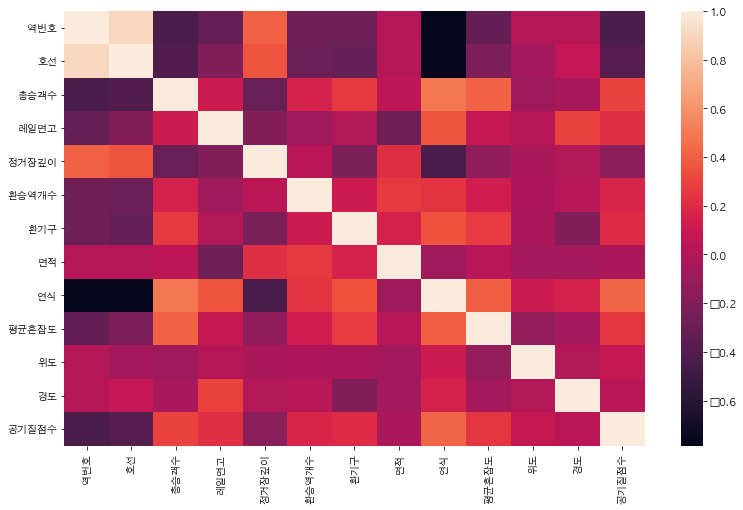

In [22]:
# 상관관계를 히트맵으로 표현함.
sns.heatmap(subway.corr())
subway.corr()

### Data Analysis

In [23]:
# folium map에 범례를 추가하는 함수 - 참조 - https://stackoverflow.com/questions/65042654/how-to-add-categorical-legend-to-python-folium-map
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [24]:
## 지도에 공기질 / 승객수를 시각화 호선별로 확인
import branca.colormap as cm

# 서울 지도
seoul_map = folium.Map(location = [37.55,126.98], zoom_start = 12, titles= 'seoul subway')

line_color = {1:'blue', 2:'green', 3:'orange', 4:'skyblue', 5:'purple', 6:'brown', 7:'olive', 8:'pink', 9:'beige'}
colormap = cm.LinearColormap(colors=['blue', 'red'], index=[0.0,1.0],vmin=0.0,vmax=1.0)


seoul_map = add_categorical_legend(seoul_map, '호선',
                             colors = [line_color[line] for line in range(1,9)],
                           labels = [f"{line}호선" for line in range(1,9)])



for name, lat, lng, num, air, train in zip(subway.역명, subway.위도, subway.경도, subway.총승객수, subway.공기질점수, subway.호선):
    folium.CircleMarker([lat, lng],
                        radius = num*40,
                        color = line_color[train],
                        fill=True,
                        fill_color= colormap(air),
                        fill_opacity=0.7,
                        weight = 3,
                        popup=name).add_to(seoul_map)


seoul_map


In [25]:
# K Means 클러스터링을 이용하여 역들을 군집화함

from sklearn.cluster import KMeans
np.random.seed(315) # 실험의 재현을 위하여

air_df = subway.loc[:, ['공기질점수', '평균혼잡도', '환승역개수']]
distortions = []
labels = []

for k in range(1, 10):
    model = KMeans(n_clusters = k)
    labels.append(model.fit_predict(air_df))
    distortions.append(model.inertia_)

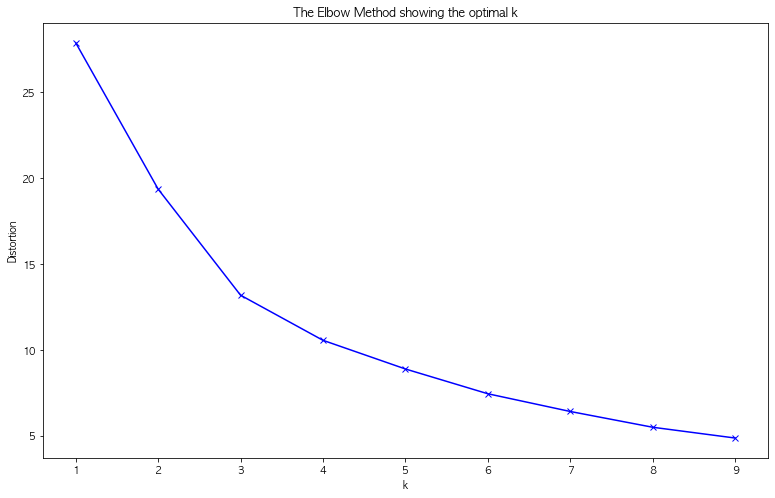

In [26]:
# Elbow Point(3)를 군집의 개수로 사용함
plt.plot(range(1, 10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
# 공기질점수와 환승역개수가 가장 큰 0번 군집을 사용함

subway['군집'] = labels[2]
군집별점수 = subway.groupby('군집').mean().loc[:, ['공기질점수', '평균혼잡도', '환승역개수']]
군집별점수.loc[3, :] = subway.loc[:, ['공기질점수', '평균혼잡도', '환승역개수']].mean(axis= 0)
군집별점수

,공기질점수,평균혼잡도,환승역개수
군집,,,
0,0.401516,0.622347,0.392157
1,0.358008,0.653357,0.000000
2,0.290267,0.244424,0.060606
3,0.351653,0.531096,0.128852


In [28]:
## 지도에 0번 군집을 하얀색 테두리로 표시하여 나타냄
import branca.colormap as cm

# 서울 지도
seoul_map = folium.Map(location = [37.55,126.98], zoom_start = 12, titles= 'seoul subway')

line_color = {0:'white', 1:'black', 2:'black'}
colormap = cm.LinearColormap(colors=['blue', 'red'], index=[0.0,1.0],vmin=0.0,vmax=1.0)


seoul_map = add_categorical_legend(seoul_map, '후보구역',
                             colors = [line_color[line] for line in range(3)],
                           labels = ["후보구역", "비후보구역", "비후보구역"])



for name, lat, lng, num, air, train, label in zip(subway.역명, subway.위도, subway.경도, subway.총승객수, subway.공기질점수, subway.호선, labels[2]):
    folium.CircleMarker([lat, lng],
                        radius = num*40,
                        color = line_color[label],
                        fill=True,
                        fill_color= colormap(air),
                        fill_opacity=0.7,
                        weight = 3,
                        popup=name,
                        tooltip=str(train)+"호선"+name).add_to(seoul_map)
    



seoul_map


In [29]:
from statsmodels.api import OLS

# 선정지수를 만들기 위해, 선형회귀에 모든 변수를 다 넣고 p-value를 확인함
x = subway.loc[:, ["레일면고", "총승객수", "정거장깊이", "환기구", "면적", "연식"]]
y = subway['공기질점수']

model = OLS(y, x)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  공기질점수   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.848
Method:                 Least Squares   F-statistic:                              222.4
Date:                Mon, 24 Jan 2022   Prob (F-statistic):                    3.04e-93
Time:                        17:38:42   Log-Likelihood:                          114.73
No. Observations:                 238   AIC:                                     -217.5
Df Residuals:                     232   BIC:                                     -196.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
레일면고           0.2017      0.061      3.290      0.001       0.081       0.322
총승객수           0.1636      0.080      2.043      0.042       0.006       0.321
정거장깊이          0.1822      0.064      2.861      0.005       0.057       0.308
환기구            0.1122      0.054      2.063      0.040       0.005       0.219
면적             0.0345      0.074      0.467      0.641      -0.111       0.180
연식             0.2805      0.057      4.920      0.000       0.168       0.393
==============================================================================
Omnibus:                       16.280   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.062
Skew:                           0.522   Prob(JB):                     4.40e-05
Kurtosis:                       3.966   Cond. No.                         7.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# 유의하지 않은 면적변수를 빼고 다시 모델링
x = subway.loc[:, ["총승객수", "레일면고", "정거장깊이", "환기구", "연식"]]
y = subway['공기질점수']

model = OLS(y, x)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  공기질점수   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              267.8
Date:                Mon, 24 Jan 2022   Prob (F-statistic):                    1.97e-94
Time:                        17:38:42   Log-Likelihood:                          114.61
No. Observations:                 238   AIC:                                     -219.2
Df Residuals:                     233   BIC:                                     -201.9
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총승객수           0.1676      0.079      2.110      0.036       0.011       0.324
레일면고           0.1971      0.060      3.263      0.001       0.078       0.316
정거장깊이          0.1956      0.057      3.442      0.001       0.084       0.308
환기구            0.1196      0.052      2.299      0.022       0.017       0.222
연식             0.2820      0.057      4.963      0.000       0.170       0.394
==============================================================================
Omnibus:                       16.218   Durbin-Watson:                   1.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.049
Skew:                           0.519   Prob(JB):                     4.43e-05
Kurtosis:                       3.973   Cond. No.                         7.58
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# 각각의 지표들과 가중합을 통해 스코어를 얻고, 해당 스코어순으로 데이터프레임을 정렬함
subway['선정지수'] = fitted_model.predict(x)
subway_label0 = subway[labels[2] == 0]
subway_sorted = subway_label0.sort_values(by='선정지수' ,ascending=False)

In [34]:
# 입지로 선정된 구역을 지도에 마커로 표시
import branca.colormap as cm

# 서울 지도
seoul_map = folium.Map(location = [37.55,126.98], zoom_start = 12, titles= 'seoul subway')

line_color = {1:'blue', 2:'green', 3:'orange', 4:'skyblue', 5:'purple', 6:'brown', 7:'olive', 8:'pink', 9:'beige'}
colormap = cm.LinearColormap(colors=['blue', 'red'], index=[0.0,1.0],vmin=0.0,vmax=1.0)


seoul_map = add_categorical_legend(seoul_map, '호선',
                             colors = [line_color[line] for line in range(1,9)],
                           labels = [f"{line}호선" for line in range(1,9)])



for name, lat, lng, num, air, train, label in zip(subway.역명, subway.위도, subway.경도, subway.총승객수, subway.공기질점수, subway.호선, labels[2]):
    folium.CircleMarker([lat, lng],
                        color = line_color[train],
                        fill=True,
                        fill_color= 'white',
                        fill_opacity=0.7,
                        weight = 3,
                        popup=name,
                        tooltip=str(train)+"호선"+name).add_to(seoul_map)
    

subway_sorted = subway_sorted.iloc[:3 ,:]
for line, name, lat, lng, num in zip(subway_sorted.호선, subway_sorted.역명, subway_sorted.위도, subway_sorted.경도, subway_sorted.총승객수):
    folium.Marker([lat, lng]).add_to(seoul_map)



seoul_map


### Conclusion
- 공기질과 가장 상관관계가 높은 변수는 준공년도(연식) 이었다.    
    - 예상외로 환풍구의 개수나, 총 승객수는 공기질과 상관관계가 크지 않았다.  
    
       
- 클러스터링을 통해, 공기청정장치의 입지 후보구역을 선정하였다.  
    - 인원수가 높고, 혼잡도가 높으며, 환승역의 개수가 많은 클러스터를 후보구역으로 선정하였다.  
      
      
- 입지선정지수를 계산하여, 최종 입지를 선정하였다.
    - 입지선정이 높으며, 클러스터에 속하는 3가지 역을 최종 입지로 선정하였다.  
    - 해당된 역은 1호선 서울역, 2호선 시청역, 2호선 강남역이다.

### References

- https://www.kaggle.com/austinreese/craigslist-carstrucks-data
- https://stackoverflow.com/questions/65042654/how-to-add-categorical-legend-to-python-folium-map
- https://predictivehacks.com/k-means-elbow-method-code-for-python/ # kmeans
- https://blog.naver.com/111ambition/222503252689
- https://teddylee777.github.io/visualization/folium